In [94]:
from vampyr import vampyr3d as vp
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.special import legendre, laguerre, erf
from scipy.constants import hbar
from vampyr import InterpolatingBasis, project, apply, build_grid, multiply
from vampyr import copy_func, copy_grid, add, dot, gradient

# Parameters:
min_scale = -4
max_depth = 25
order = 8
prec = 1e-6
corner = [-1, -1, -1]
boxes = [2, 2, 2]

# MRA World setup
world = vp.BoundingBox(min_scale, corner, boxes)
basis = InterpolatingBasis(order)
MRA = vp.MultiResolutionAnalysis(world, basis, max_depth)

phi_n = vp.FunctionTree(MRA)  # will contain the current loop orbital
nuclear_potential = vp.FunctionTree(MRA) # will contain the projected nuclear potential

def u(r):
    u = erf(r)/r + (1/(3*np.sqrt(np.pi)))*(np.exp(-(r**2)) + 16*np.exp(-4*r**2))
    #erf(r) is an error function that is supposed to stop the potential well from going to inf.
    #if i remember correctly
    return u

def V(x):
    r = np.sqrt(x[0]**2 + x[1]**2 + x[2]**2)
    c = 0.00435
    f_bar = u(r/c)/c
    return f_bar

project(prec, nuclear_potential, V)

# creating starting guess from a gaussian function

alpha = 3.0
beta = np.sqrt(alpha/np.pi)**3
gauss = vp.GaussFunc(beta, alpha)
build_grid(phi_n, gauss)
project(prec, phi_n, gauss)
phi_n.normalize()

#D = vp.ABGVOperator(MRA, 0.0, 0.0)
#grad = gradient(D, phi_n)
#x_plt = np.linspace(-1.0, 1.0, 1000)
#phi_n_plt = [phi_n.evalf([x, 0.0, 0.0]) for x in x_plt]
#grad0_plt = [grad[0][1].evalf([x, 0.0, 0.0]) for x in x_plt]
#grad1_plt = [grad[1][1].evalf([0.0, x, 0.0]) for x in x_plt]
#grad2_plt = [grad[2][1].evalf([0.0, 0.0, x]) for x in x_plt]
#plt.plot(x_plt, phi_n_plt)
#plt.plot(x_plt, grad0_plt)
#plt.plot(x_plt, grad1_plt)
#plt.plot(x_plt, grad2_plt)

  square norm: 1
  root scale: -4
  order: 8
  nodes: 456
  endNodes: 400
  genNodes: 0
  nodes per scale: 
    scale=-4  nodes=8
    scale=-3  nodes=64
    scale=-2  nodes=64
    scale=-1  nodes=64
    scale=0  nodes=64
    scale=1  nodes=64
    scale=2  nodes=64
    scale=3  nodes=64



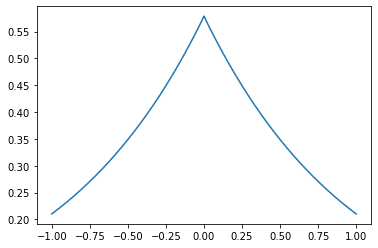

In [95]:
energy = -0.5;
energy_correction = 1.0;

#while np.abs(energy_correction) > 0.01:
for i in range(5):
    phi_n.normalize()
    phi_np1 = vp.FunctionTree(MRA)

    temp1_tree = vp.FunctionTree(MRA)
    temp2_tree = vp.FunctionTree(MRA)
    multiply(prec, temp1_tree, 1.0, phi_n, nuclear_potential)

    mu = np.sqrt(-2*energy)
    H = vp.HelmholtzOperator(MRA, mu, prec)    
    apply(prec, phi_np1, H, temp1_tree)
    phi_np1.rescale(1.0/(2*np.pi))

    delta_phi = vp.FunctionTree(MRA)
    add(prec/10, delta_phi, 1.0, phi_np1, -1.0, phi_n)

    multiply(prec, temp2_tree, 1.0, delta_phi, nuclear_potential)
    energy_correction = dot(phi_np1, temp2_tree)/phi_np1.getSquareNorm()
    phi_n = vp.FunctionTree(MRA)
    copy_grid(phi_n, phi_np1)
    copy_func(phi_n, phi_np1)

    while abs(energy_correction) > abs(energy): 
        energy_correction /= 2
    
    energy -= energy_correction

x_plt = np.linspace(-1.0, 1.0, 1000)
phi_np1_plt = [phi_np1.evalf([x, 0.0, 0.0]) for x in x_plt]
plt.plot(x_plt, phi_np1_plt)
phi_n.normalize()
print(phi_n)

In [124]:
c = 1

def init_function(orbital, function, component):
    copy_grid(orbital[component], function)
    copy_func(orbital[component], function)
    
def init_empty_orbital():
    orbital = {'Lar': vp.FunctionTree(MRA),
               'Lai': vp.FunctionTree(MRA),
               'Lbr': vp.FunctionTree(MRA),
               'Lbi': vp.FunctionTree(MRA),
               'Sar': vp.FunctionTree(MRA),
               'Sai': vp.FunctionTree(MRA),
               'Sbr': vp.FunctionTree(MRA),
               'Sbi': vp.FunctionTree(MRA)}
    return orbital

def init_large_components(orbital, phi_lar=None, phi_lai=None, phi_lbr=None, phi_lbi=None):
    nr_of_functions = 0
    if(phi_lar != None):
        nr_of_functions += 1
        init_function(orbital, phi_lar, 'Lar')
    if(phi_lai != None):
        nr_of_functions += 1
        init_function(orbital, phi_lai, 'Lai')
    if(phi_lbr != None):
        nr_of_functions += 1
        init_function(orbital, phi_lbr, 'Lbr')
    if(phi_lbi != None):
        nr_of_functions += 1
        init_function(orbital, phi_lbi, 'Lbi')
    if(nr_of_functions == 0):
        print("WARNING: Large components not initialized!")

def init_small_components(orbital):
    # initalize the small components based on the kinetic balance
    D = vp.ABGVOperator(MRA, 0.0, 0.0)
    grad_ar = gradient(D, orbital['Lar'])
    grad_ai = gradient(D, orbital['Lai'])
    grad_br = gradient(D, orbital['Lbr'])
    grad_bi = gradient(D, orbital['Lbi'])
    sar_tree = vp.FunctionTree(MRA)    
    sai_tree = vp.FunctionTree(MRA)    
    sbr_tree = vp.FunctionTree(MRA)    
    sbi_tree = vp.FunctionTree(MRA)    
    sum_ar = []
    sum_ar.append(tuple([-0.5/c, grad_bi[0][1]]))
    sum_ar.append(tuple([ 0.5/c, grad_br[1][1]]))
    sum_ar.append(tuple([-0.5/c, grad_ai[2][1]]))
    add(prec/10, sar_tree, sum_ar)
    sum_ai = []
    sum_ai.append(tuple([ 0.5/c, grad_br[0][1]]))
    sum_ai.append(tuple([ 0.5/c, grad_bi[1][1]]))
    sum_ai.append(tuple([ 0.5/c, grad_ar[2][1]]))
    add(prec/10, sai_tree, sum_ai)
    sum_br = []
    sum_br.append(tuple([-0.5/c, grad_ai[0][1]]))
    sum_br.append(tuple([-0.5/c, grad_ar[1][1]]))
    sum_br.append(tuple([ 0.5/c, grad_bi[2][1]]))
    add(prec/10, sbr_tree, sum_br)
    sum_bi = []
    sum_bi.append(tuple([ 0.5/c, grad_ar[0][1]]))
    sum_bi.append(tuple([-0.5/c, grad_ai[1][1]]))
    sum_bi.append(tuple([-0.5/c, grad_br[2][1]]))
    add(prec/10, sbi_tree, sum_bi)
    init_function(orbital, sar_tree, 'Sar')
    init_function(orbital, sai_tree, 'Sai')
    init_function(orbital, sbr_tree, 'Sbr')
    init_function(orbital, sbi_tree, 'Sbi')
    return
    
def compute_orbital_gradient(orbital):
    D = vp.ABGVOperator(MRA, 0.0, 0.0)
    orb_grad = {}
    for comp, func in orbital.items():
        orb_grad[comp] = gradient(D, func) 
    return orb_grad

def scale_gradient_light_speed_and_sign(orb_grad):
    for comp, grad in orb_grad.items():
        for i in range(3):
            sign = grab_sign(comp, i)
            coeff = grab_coefficient(comp, i)
            lst = list(grad[i])
            lst[0] *= (sign * coeff)
            grad[i] = tuple(lst)

def grab_sign(comp, derivative):
    grab_table = {
        'Lar': ( 1, -1,  1), 
        'Lai': (-1, -1, -1), 
        'Lbr': ( 1,  1, -1), 
        'Lbi': (-1,  1,  1), 
        'Sar': ( 1, -1,  1), 
        'Sai': (-1, -1, -1), 
        'Sbr': ( 1,  1, -1), 
        'Sbi': (-1,  1,  1), 
    }
    return grab_table[comp][derivative]
    
def grab_coefficient(comp, derivative, global_factor = 1.0):
    grab_table = {
        'Lar': (1, 1, 1), 
        'Lai': (1, 1, 1), 
        'Lbr': (1, 1, 1), 
        'Lbi': (1, 1, 1), 
        'Sar': (c**2,c**2,c**2), 
        'Sai': (c**2,c**2,c**2),
        'Sbr': (c**2,c**2,c**2),
        'Sbi': (c**2,c**2,c**2)
    }
#    return grab_table[comp][derivative] * global_factor
    return c
    
def grab_component(comp, derivative):
    grab_table = {
        'Lar': ('Sbi', 'Sbr', 'Sai'), 
        'Lai': ('Sbr', 'Sbi', 'Sar'), 
        'Lbr': ('Sai', 'Sar', 'Sbi'), 
        'Lbi': ('Sar', 'Sai', 'Sbr'), 
        'Sar': ('Lbi', 'Lbr', 'Lai'), 
        'Sai': ('Lbr', 'Lbi', 'Lar'), 
        'Sbr': ('Lai', 'Lar', 'Lbi'), 
        'Sbi': ('Lar', 'Lai', 'Lbr'), 
    }
    return grab_table[comp][derivative]
    
def assemble_vectors(orb, orb_grad):
    add_orbitals = {}
    for comp, func in orb.items():
        add_orbitals[comp] = []
        if(func.getSquareNorm() > 0):
            add_orbitals[comp].append((c**2, func))
#        else:
#            print(comp, " function was empty")
        for idx in range(3):
            comp_der = grab_component(comp, idx)
            if(orb_grad[comp_der][idx][1].getSquareNorm() > 0):
                add_orbitals[comp].append(orb_grad[comp_der][idx])
#            else:
#                print(comp_der, " function for ", comp, " was empty")
    return add_orbitals

def apply_dirac_hamiltonian(orbital):
    out_orbital = init_empty_orbital()
    orb_grad = compute_orbital_gradient(orbital)
    scale_gradient_light_speed_and_sign(orb_grad)
    add_vectors = assemble_vectors(orbital, orb_grad)
    for comp, func in out_orbital.items():
#        print("adding contributions for ", comp)
#        print(add_vectors[comp])
        add(prec/10, func, add_vectors[comp])
    return out_orbital

def apply_potential(V, orbital):
    out_orbital = init_empty_orbital()
    for comp, func in orbital.items():
        if func.getSquareNorm() > 0:
            multiply(prec, out_orbital[comp], 1, nuclear_potential, func)
    return out_orbital

def add_orbitals(a, orb_a, b, orb_b):
    out_orb = init_empty_orbital()
    for comp, func in out_orb.items():
        func_a = orb_a[comp]
        func_b = orb_b[comp]
        if (func_a.getSquareNorm() > 0 and func_b.getSquareNorm() > 0):
            add(prec/10, func, a, func_a, b, func_b)
        elif(func_a.getSquareNorm() > 0):
            init_function(out_orb, func_a, comp)
            func.rescale(a)
        elif(func_b.getSquareNorm() > 0):
            init_function(out_orb, func_b, comp)
            func.rescale(b)
        else:
            print('Warning: adding two empty trees')
    return out_orb

def scalar_product(orb_a, orb_b):
    out_real = 0
    out_imag = 0
    for comp in ['La']:
        factor = 1
#        if('S' in comp):
#            factor = c**2
        real_comp = comp + 'r'
        imag_comp = comp + 'i'
        ac = 0
        bd = 0
        ad = 0
        bc = 0
        func_a = orb_a[real_comp]
        func_b = orb_a[imag_comp]
        func_c = orb_b[real_comp]
        func_d = orb_b[imag_comp]
        if(func_a.getSquareNorm() > 0 and func_c.getSquareNorm() > 0):
           ac = dot(func_a, func_c)
        if(func_b.getSquareNorm() > 0 and func_d.getSquareNorm() > 0):
           bd = dot(func_b, func_d)
        if(func_a.getSquareNorm() > 0 and func_d.getSquareNorm() > 0):
           ad = dot(func_a, func_d)
        if(func_b.getSquareNorm() > 0 and func_c.getSquareNorm() > 0):
           bc = dot(func_b, func_c)
        out_real += (ac + bd) / factor
        out_imag += (ad - bc) / factor
    return out_real, out_imag

def compute_dirac_energy(n,Z,k,c):
    tmp1 = 1.0/np.abs(k) - 3.0/(4*n)
    tmp2 = 1 + tmp1 * Z**2 / (n * c**2)
    return c**2 - tmp2 * Z**2 / (2*n**2)

orbital = init_empty_orbital()
init_large_components(orbital,phi_n)
init_small_components(orbital)
hD_psi = apply_dirac_hamiltonian(orbital)
v_psi = apply_potential(V, orbital)
add_psi = add_orbitals(1.0, hD_psi, -1.0, v_psi)
norm_sq,imag = scalar_product(orbital, orbital)
real,imag = scalar_product(orbital, add_psi)
exact_energy = compute_dirac_energy(1,1,-1,c)
print("computed energy ",real/norm_sq)
print("exact energy ", exact_energy)
print("difference ", exact_energy - real/norm_sq)


computed energy  0.5000819030132906
exact energy  0.375
difference  -0.12508190301329059


In [118]:
mu = np.sqrt((c**4-(real/norm_sq)**2)/c**2)
print(mu)

0.9999114352990937
